In [16]:
using PyPlot
using DataFrames
using CSV
import Statistics

In [17]:
include("./src/loop_function.jl")
include("./src/tmat.jl")
include("./src/tmat_up_to_nlo.jl")
include("./src/par.jl")
include("./src/subtraction_cons.jl")

subtraction_cons_tuple (generic function with 1 method)

In [18]:
import PyCall
iminuit = PyCall.pyimport("iminuit");

In [19]:
par_phy_channel = par_physical_channel()
# par_phy_channel[:decons] = 106.

Dict{Symbol, Any} with 5 entries:
  :threshold  => [1431.95, 1328.94, 1327.62, 1437.22, 1337.02, 1250.66]
  :mch        => [(493.68, 938.272), (139.57, 1189.37), (134.977, 1192.64), (49…
  :mB         => [938.272, 939.565, 1115.68, 1197.45, 1192.64, 1189.37]
  :meson_mass => (139.57, 134.977, 139.57, 497.65, 493.68)
  :decons     => 100.69

In [20]:
function plot_cross_section(ax, df; kwargs...)
    mKbarn = 1437.22
    ax.errorbar(df.Ecm, df.sigma, yerr=df.dsigma, fmt="s"; kwargs...)
    ax.set_ylim(0, maximum(df.sigma + df.dsigma))
    ax.vlines(mKbarn, 0, maximum(df.sigma + df.dsigma), ls="--", color="k")
    ax.legend()
end;

In [21]:
b = (-0.664609603537589, 0.062434962905761365, -0.35384103271852047)
d = (-0.3595489872519527, 0.020386885826743775, -0.1405760338940346, -0.5771420439532574)
CC = lecs_cij()
DD = lec_bi(par_phy_channel, b)
LL = lec_di(d)
qmax_nlo = 709.8420762525412
mu=630e0
anlo_phy_channel = Tuple(subtraction_cons(par_phy_channel[:mch][i], mu, qmax_nlo) for i in 1:6);

In [22]:
data_path = "./lambda1405_data/lambda1405_data/";

Kmp_to_Kbar0n = CSV.read(data_path * "Kmp_to_Kbar0n.csv", DataFrame)
Kmp_to_Kmp = CSV.read(data_path * "Kmp_to_Kmp.csv", DataFrame)
Kmp_to_Lampi0 = CSV.read(data_path * "Kmp_to_Lampi0.csv", DataFrame)
Kmp_to_Sig0pi0 = CSV.read(data_path * "Kmp_to_Sig0pi0.csv", DataFrame)
Kmp_to_Sigmpip = CSV.read(data_path * "Kmp_to_Sigmpip.csv", DataFrame)
Kmp_to_Sigppim = CSV.read(data_path * "Kmp_to_Sigppim.csv", DataFrame);

mKbarn = 1437.22
# filter!(df -> df.Ecm >= mKbarn, Kmp_to_Kbar0n)
# filter!(df -> df.Ecm >= mKbarn, Kmp_to_Kmp)
# filter!(df -> df.Ecm >= mKbarn, Kmp_to_Lampi0)
# filter!(df -> df.Ecm >= mKbarn, Kmp_to_Sig0pi0)
# filter!(df -> df.Ecm >= mKbarn, Kmp_to_Sigmpip)
# filter!(df -> df.Ecm >= mKbarn, Kmp_to_Sigppim);

filter!(df -> 1500>= df.Ecm >= mKbarn, Kmp_to_Kbar0n)
filter!(df -> 1500>=df.Ecm >= mKbarn, Kmp_to_Kmp)
filter!(df -> 1500>=df.Ecm >= mKbarn, Kmp_to_Lampi0)
filter!(df -> 1500>=df.Ecm >= mKbarn, Kmp_to_Sig0pi0)
filter!(df -> 1500>=df.Ecm >= mKbarn, Kmp_to_Sigmpip)
filter!(df -> 1500>=df.Ecm >= mKbarn, Kmp_to_Sigppim);

w1 = Kmp_to_Kmp.Ecm
w2 = Kmp_to_Sigppim.Ecm
w3 = Kmp_to_Sig0pi0.Ecm
w4 = Kmp_to_Kbar0n.Ecm
w5 = Kmp_to_Sigmpip.Ecm
w6 = Kmp_to_Lampi0.Ecm

s1 = Kmp_to_Kmp.sigma
s2 = Kmp_to_Sigppim.sigma
s3 = Kmp_to_Sig0pi0.sigma
s4 = Kmp_to_Kbar0n.sigma
s5 = Kmp_to_Sigmpip.sigma
s6 = Kmp_to_Lampi0.sigma

ds1 = Kmp_to_Kmp.dsigma
ds2 = Kmp_to_Sigppim.dsigma
ds3 = Kmp_to_Sig0pi0.dsigma
ds4 = Kmp_to_Kbar0n.dsigma
ds5 = Kmp_to_Sigmpip.dsigma
ds6 = Kmp_to_Lampi0.dsigma;

ww = push!([], w1..., w2..., w3..., w4..., w5..., w6...)
ss = push!([], s1..., s2..., s3..., s4..., s5..., s6...)
dss = push!([], ds1..., ds2..., ds3..., ds4..., ds5..., ds6...);
len = length(ww)

232

In [23]:
function cost_fun(free_par)
    d = free_par[1:4]
    lam = free_par[5]
    anlo = Tuple(subtraction_cons(par_phy_channel[:mch][i], mu, lam) for i in 1:6)
    LLL = lec_di(d)

    ss1 = map(x -> dist_up_to_nlo_swave(x, par_phy_channel, CC, DD, LLL, anlo, :ch11), w1)
    ss2 = map(x -> dist_up_to_nlo_swave(x, par_phy_channel, CC, DD, LLL, anlo, :ch12), w2)
    ss3 = map(x -> dist_up_to_nlo_swave(x, par_phy_channel, CC, DD, LLL, anlo, :ch13), w3)
    ss4 = map(x -> dist_up_to_nlo_swave(x, par_phy_channel, CC, DD, LLL, anlo, :ch14), w4)
    ss5 = map(x -> dist_up_to_nlo_swave(x, par_phy_channel, CC, DD, LLL, anlo, :ch15), w5)
    ss6 = map(x -> dist_up_to_nlo_swave(x, par_phy_channel, CC, DD, LLL, anlo, :ch16), w6)
    ss_th = push!([], ss1..., ss2..., ss3..., ss4..., ss5..., ss6...)
    y = (ss_th - ss) ./ dss
    return y' * y
end

cost_fun (generic function with 1 method)

In [24]:
free_par = [-0.3595489872519527, 0.020386885826743775, -0.1405760338940346, -0.5771420439532574, 709.8420762525412]
name = [:d1, :d2, :d3, :d4, :lam]
fit = iminuit.Minuit(x -> cost_fun(x), free_par, name=name)
# fit.limits = [(-1, 1), (0.02, 0.0204), (-1, 1), (-1, 1), (700e0, 1200e0)]
# fit.limits[5] = (545e0, 1200)
# fit.fixed[2] = true
fit.fixed[5] = true
# fit.fixed=true
fit

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,d1,-0.360,0.004,,,,,
1,d2,20.39e-3,0.20e-3,,,,,
2,d3,-0.1406,0.0014,,,,,
3,d4,-0.577,0.006,,,,,
4,lam,710,7,,,,,yes


In [25]:
fit.migrad()
println("The reduced χ^2 is $(fit.fval / (len - fit.nfit))")
fit

The reduced χ^2 is 4.41678558750038


PyObject <FMin algorithm='Migrad' edm=2.251432912728967e-05 edm_goal=0.0002 errordef=1.0 fval=1007.0271139500867 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=152 ngrad=0 reduced_chi2=nan time=4.614900173037313>
(Param(number=0, name='d1', value=-0.28001246763943766, error=0.0019673875274154144, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=1, name='d2', value=-0.020581228202457662, error=0.0022459162873759817, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=2, name='d3', value=-0.14544792976566118, error=0.0021075882182920893, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=3, name='d4', value=-0.5623889106203804, error=0.003517667144037763, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=4, name='lam', value=709.8420762525412, error=7.0984207625254125, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None))
[[ 3.87061368e-06  5.63871337e-07 -2.25176106e-06 -1.72231050e-06
   0.00000000e+00]
 [ 5.63871337e-07  5.04413997e-06  7.53826841e-07 -6.01255786e-06
   0.00000000e+00]
 [-2.25176106e-06  7.53826841e-07  4.44192810e-06  1.60512492e-07
   0.00000000e+00]
 [-1.72231050e-06 -6.01255786e-06  1.60512492e-07  1.23739821e-05
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]

In [26]:
val = Tuple(fit.values)

(-0.28001246763943766, -0.020581228202457662, -0.14544792976566118, -0.5623889106203804, 709.8420762525412)

In [27]:

d = val[1:4]
lam = val[5]
anlo = Tuple(subtraction_cons(par_phy_channel[:mch][i], mu, lam) for i in 1:6)
LL = lec_di(d)

6×6 Matrix{Float64}:
 -0.00131139    0.000113983   4.84892e-6   …  -0.000104285   0.000260322
  0.000113983  -0.00131139   -0.000104285     -0.000208571   0.0
  4.84892e-6   -0.000104285  -0.00141567      -0.000104285   0.0
 -0.000446042  -0.000104285   4.84892e-6       0.000113983   0.000260322
 -0.000104285  -0.000208571  -0.000104285     -0.00131139    0.0
  0.000260322   0.0           0.0          …   0.0          -0.00112478

In [28]:
w = mKbarn:0.01:1500e0
sc1 = map(x -> dist_up_to_nlo_swave(x, par_phy_channel, CC, DD, LL, anlo, :ch11), w);
sc2 = map(x -> dist_up_to_nlo_swave(x, par_phy_channel, CC, DD, LL, anlo, :ch12), w);
sc3 = map(x -> dist_up_to_nlo_swave(x, par_phy_channel, CC, DD, LL, anlo, :ch13), w);
sc4 = map(x -> dist_up_to_nlo_swave(x, par_phy_channel, CC, DD, LL, anlo, :ch14), w);
sc5 = map(x -> dist_up_to_nlo_swave(x, par_phy_channel, CC, DD, LL, anlo, :ch15), w);
sc6 = map(x -> dist_up_to_nlo_swave(x, par_phy_channel, CC, DD, LL, anlo, :ch16), w);

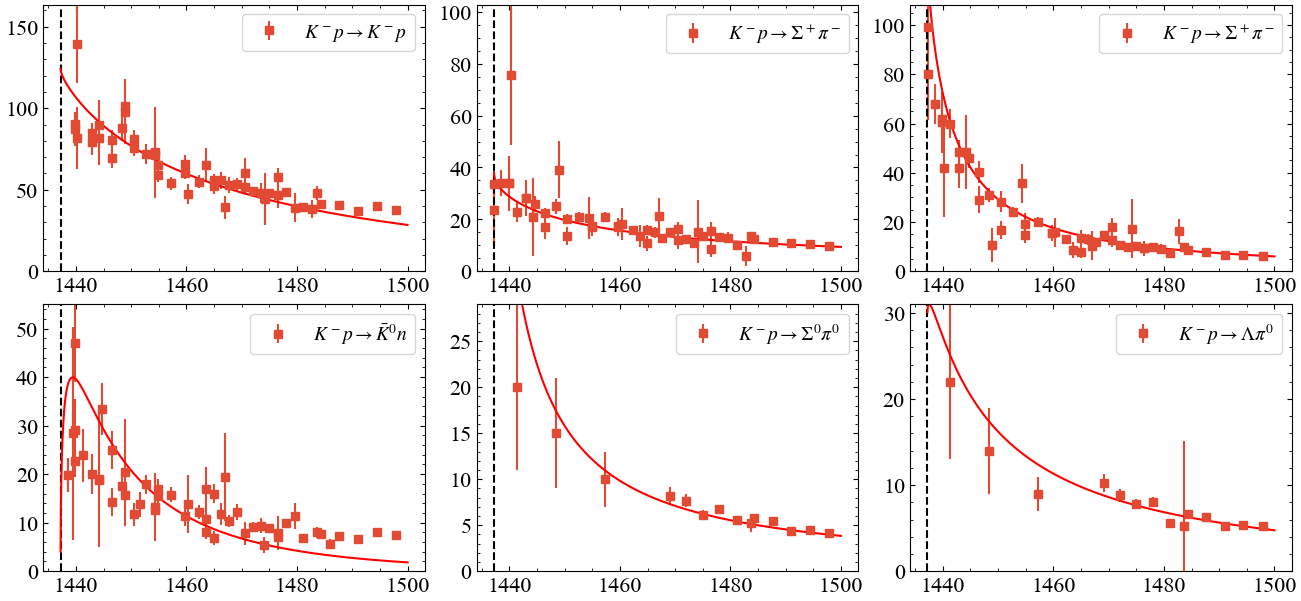

In [29]:
fig, ax = PyPlot.subplots(2, 3, layout="constrained", figsize=(13, 6))
plot_cross_section(ax[1, 1], Kmp_to_Kmp, label=L"K^- p \to K^- p") # 11
plot_cross_section(ax[1, 2], Kmp_to_Sigppim, label=L"K^- p \to \Sigma^+\pi^-") # 12
plot_cross_section(ax[1, 3], Kmp_to_Sigmpip, label=L"K^- p \to \Sigma^+\pi^-") # 15

plot_cross_section(ax[2, 1], Kmp_to_Kbar0n, label=L"K^- p \to \bar{K}^0 n") # 14
plot_cross_section(ax[2, 2], Kmp_to_Sig0pi0, label=L"K^- p \to \Sigma^0 \pi^0") # 13
plot_cross_section(ax[2, 3], Kmp_to_Lampi0, label=L"K^- p \to \Lambda\pi^0") # 16

ax[1, 1].plot(w, sc1, c="r")
ax[1, 2].plot(w, sc2, c="r")
ax[1, 3].plot(w, sc5, c="r")


ax[2, 1].plot(w, sc4, c="r")
ax[2, 2].plot(w, sc3, c="r")
ax[2, 3].plot(w, sc6, c="r")
fig.savefig("./figure/lambda_fitted.png")
gcf()